# Project 3

By Helin Yilmaz

Using data from the graph database to perform a temporal analysis tracking the representation of various historical periods in the Met's collection each year.

# Environment setup

In [1]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd
import psycopg2
from IPython.display import display
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import seaborn as sns

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()

## Setting up Neo4j. Web server interface at https://xxxx:7473

#### Update - since the videos were filmed, neo4j requires a longer, more complex password, so the newest password is here:

**Username: neo4j**

**Password: ucb_mids_w205**

**In the web server interface, run the same query from last week to return all nodes and all relationships:**

```
match (n) return n
```

In [5]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [6]:
session = driver.session(database="neo4j")

### Helpful functions

In [7]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [8]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [9]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

In [10]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"
   
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")

### Verify the number of nodes and relationships

In [11]:
my_neo4j_number_nodes_relationships()   

-------------------------
  Nodes: 8607
  Relationships: 17844
-------------------------


## Temporal Graph Analysis

In [12]:
def temporal_graph_analysis_yearly(driver):
    """
    Performs temporal graph analysis to track the representation of historical
    periods in the Met's collection each year.
    """
    with driver.session(database="neo4j") as session:
        query = """
        MATCH (a:Artwork)-[:ASSOCIATED_WITH]-(t:TimePeriod)
        RETURN a.accessionyear AS accessionyear, t.century AS century, COUNT(a) AS artwork_count
        ORDER BY a.accessionyear, t.century
        """
        results = session.run(query)

        # Storing results into a pandas DataFrame
        data = [{"accessionyear": record["accessionyear"], "century": record["century"], "artwork_count": record["artwork_count"]} for record in results]
        df = pd.DataFrame(data)

        # Removing null accession year values.
        df = df.dropna(subset=['accessionyear'])
        df['accession_year'] = df['accessionyear'].astype(int)

        # Using the DataFrame to create a time series format
        time_series_df = df.pivot_table(index='accessionyear', columns='century', values='artwork_count', fill_value=0)

        return time_series_df


In [26]:
def visualize_temporal_analysis(time_series_df):
    """Visualizes the temporal analysis results using both a combined line chart
    and faceted line charts, excluding accession years before 1800.
    """

    filtered_df = time_series_df[time_series_df.index >= 1700] # Filtering for non-valid accession years
    min_year = filtered_df.index.min()
    max_year = filtered_df.index.max()

    # 1. Combined Line Chart
    plt.figure(figsize=(12, 6))
    for century in filtered_df.columns:
        plt.plot(filtered_df.index, filtered_df[century], label=century)
    plt.xlabel("Accession Year")
    plt.ylabel("Artwork Count")
    plt.title("Representation of Historical Periods Over Time In the Met Collection (from 1800)")
    plt.legend(title="Century", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.xlim(min_year, max_year)
    plt.tight_layout()
    plt.show()
    
    print()

    # 2. Faceted Line Charts
    # Reshape the DataFrame for Seaborn
    df_separated = pd.melt(filtered_df.reset_index(),
                        id_vars='accessionyear',
                        value_vars=filtered_df.columns,
                        var_name='century',
                        value_name='artwork_count')

    # Create the faceted line charts
    g = sns.relplot(data=df_separated,
                    x='accessionyear',
                    y='artwork_count',
                    col='century',
                    col_wrap=3,
                    kind='line',
                    marker='o',
                    linestyle='-',
                    height=3,
                    aspect=1.5)
    g.fig.suptitle("Artwork Count by Century Over Accession Year (Faceted, from 1800)", y=1.02)
    g.set_axis_labels("Accession Year", "Artwork Count")

    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.set_xlim(min_year, max_year)

    plt.tight_layout()
    plt.show()

In [27]:
time_series_df = temporal_graph_analysis_yearly(driver)

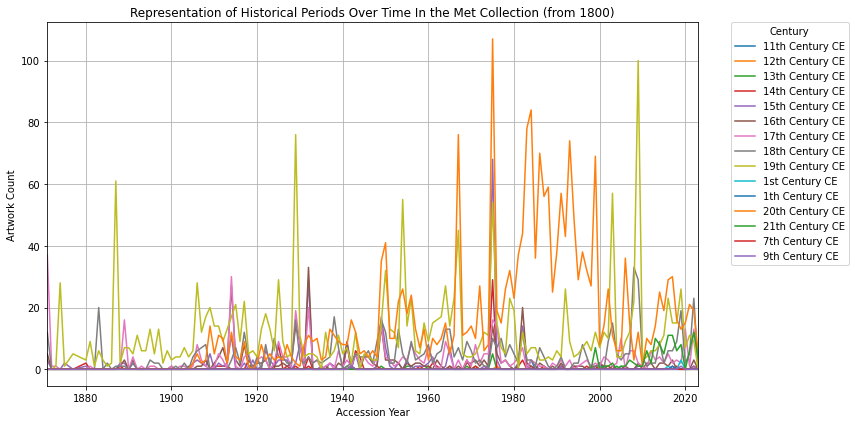

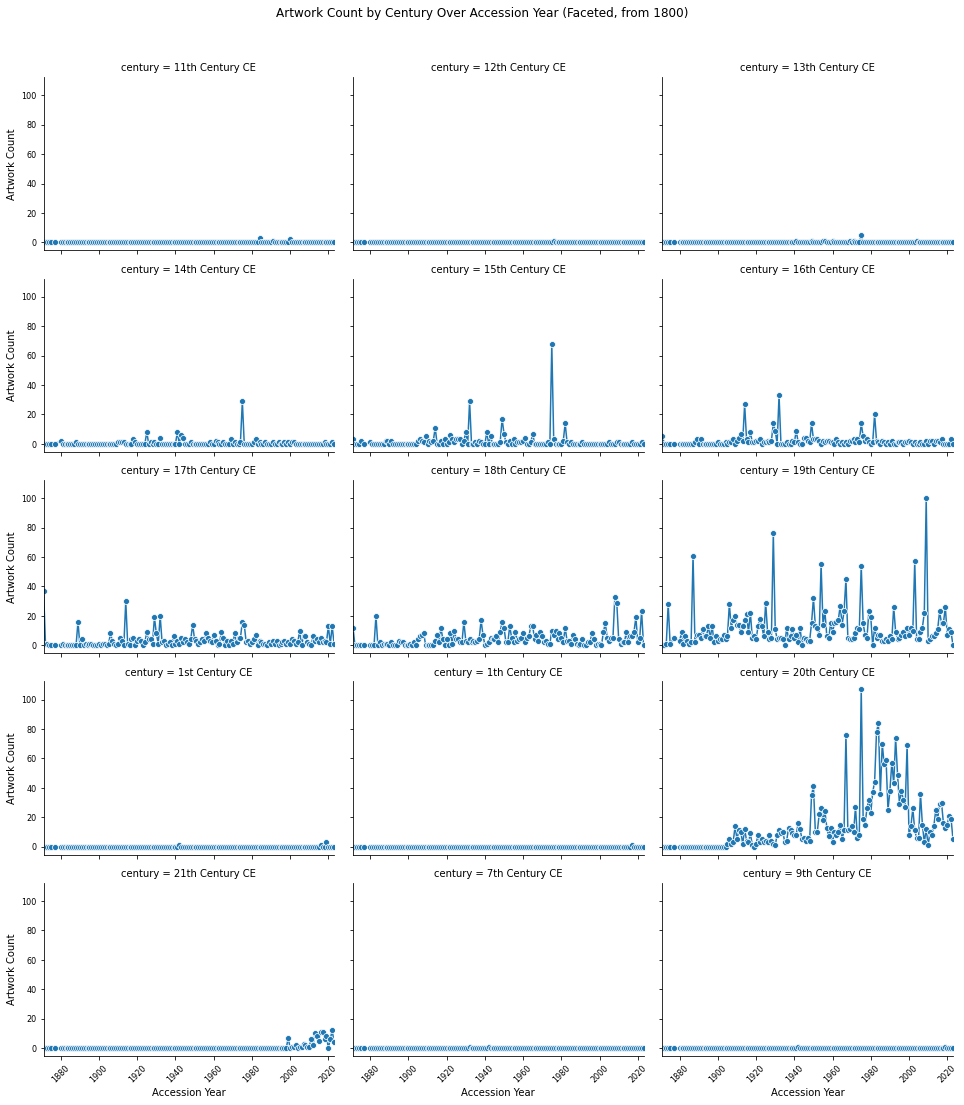

In [28]:
visualize_temporal_analysis(time_series_df)

In [29]:
time_series_df.tail()

century,11th Century CE,12th Century CE,13th Century CE,14th Century CE,15th Century CE,16th Century CE,17th Century CE,18th Century CE,19th Century CE,1st Century CE,1th Century CE,20th Century CE,21th Century CE,7th Century CE,9th Century CE
accessionyear,,,,,,,,,,,,,,,
2019,0,0,0,0,0,0,2,19,26,3,0,13,8,0,1
2020,0,0,0,0,0,0,13,2,7,0,0,15,0,0,0
2021,0,0,0,0,0,0,1,5,11,0,0,21,6,0,0
2022,0,0,0,1,1,3,13,23,9,0,0,19,12,0,0
2023,0,0,0,0,0,0,1,0,0,0,0,5,4,0,0
